In [1]:
import pandas as pd
import numpy as np

# import path
import seaborn as sns
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *

import re
import utils

from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt

In [2]:
assert 'apply_functions' in dir(utils)

In [3]:
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

#### Sticking to only train dataset analyses since we are focussed on the implications of unigrams within "text" field on target

In [4]:
train=pd.read_csv('data/train.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train['location'].fillna('No',inplace = True)
train['keyword'].fillna('No',inplace = True) 

In [6]:
list_of_functions = [utils.clean, utils.remove_emoji, utils.remove_html]
train['text'] = utils.apply_functions(train['text'], list_of_functions)

In [7]:
custom_vec = CountVectorizer(ngram_range=(1,3),
                             stop_words='english')
cwm = custom_vec.fit_transform(train.text.values)
tokens = custom_vec.get_feature_names()
# wm2df(cwm, tokens)

In [8]:
disaster = train.target.values.reshape(-1,1).astype(float)

In [9]:
word_occurence_matrix = (cwm>0).astype(float)

In [14]:
word_non_occurence_matrix = (word_occurence_matrix!=1).astype(float)

/home/vix/Desktop/Projects/fastai_all_materials/fastai_all_materials/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3319: SparseEfficiencyWarning: Comparing a sparse matrix with a nonzero scalar using != is inefficient, try using == instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
word_occurence_sum = word_occurence_matrix.sum(axis=0)

In [16]:
word_non_occurence_sum = word_non_occurence_matrix.sum(axis=0)

In [17]:
disaster_word_combined_occurence = (disaster * word_occurence_matrix.toarray()).astype(float)

In [18]:
disaster_word_combined_sum = disaster_word_combined_occurence.sum(axis=0)

In [19]:
P_disaster_given_word = disaster_word_combined_sum / word_occurence_sum

In [20]:
disaster_non_word_combined_occurence = (disaster * word_non_occurence_matrix.toarray()).astype(float)

In [21]:
disaster_non_word_combined_sum = disaster_non_word_combined_occurence.sum(axis=0)

In [22]:
P_disaster_given_non_word = disaster_non_word_combined_sum / word_non_occurence_sum

In [23]:
problift_disaster = P_disaster_given_word/P_disaster_given_non_word

In [24]:
problift_df = pd.DataFrame(np.concatenate([problift_disaster.reshape(-1,1), 
              word_occurence_sum.reshape(-1,1)], axis=1), 
             columns = ['problift', 'word_count'])
del cwm

In [25]:
problift_df['word'] = tokens

In [26]:
problift_df = problift_df[['word', 'word_count', 'problift']]

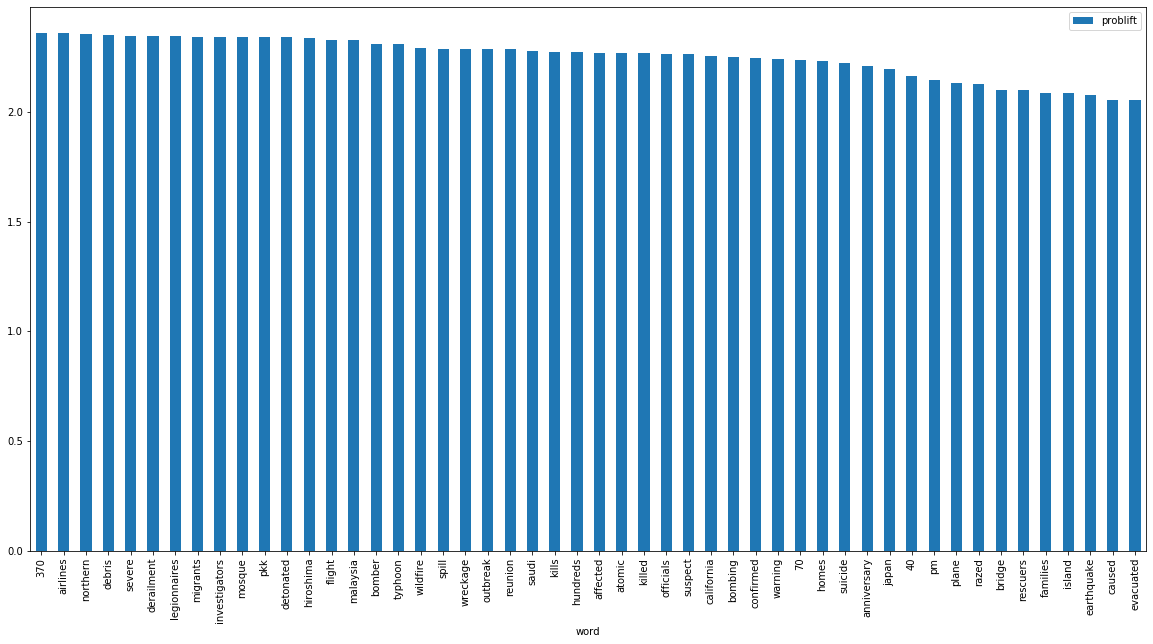

In [27]:
problift_df.loc[problift_df.word_count > 30, ['word','problift']].sort_values('problift', ascending=False)[:50].set_index('word').plot(kind='bar', figsize=(20,10))
plt.savefig('123grams.png')